In [198]:
# The purpose of this script is to enable us to 
# run all the experiments by a single-line command 
# Arguments:
#   - Choice to pick Influence Function or Fusion Collison
#   - Choice to pick datasets (from ImageNet) 
#     by specifying the categories' names 
#   - Choice to pick num_train_per_class and num_test_per_class
#   - Choice to pick which experiments 
#   - Flexibility to pick the target test point 
#   - If test point chosen, flexibility to pick the target training point
#
# Outputs:
#   - Render the original selected training image, the poisoned image, and the target test point
#   - Give the model's initial prediction on the target test point
#   - Give the new model's final predicton on the target test point
#   - Give the tsne vis 


import os
import numpy as np
import IPython
import copy
from shutil import copyfile

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base

import sys
sys.dont_write_bytecode=True

PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))

from influence.inceptionModel import BinaryInceptionModel
from influence.logisticRegressionWithLBFGS import LogisticRegressionWithLBFGS
from influence.binaryLogisticRegressionWithLBFGS import BinaryLogisticRegressionWithLBFGS
import influence.experiments
from influence.dataset import DataSet
# from influence.dataset_poisoning import iterative_attack, select_examples_to_attack, get_projection_to_box_around_orig_point, generate_inception_features
from influence.iter_attack import iterative_attack, select_examples_to_attack, get_projection_to_box_around_orig_point, generate_inception_features
from influence.Progress import *

from load_animals import *
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

def render_img(img):
        img_copy = np.copy(img)
        img_copy /= 2
        img_copy += 0.5
        io.imshow(img_copy)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [199]:
# For now, pretend these are the arguments passed to the script 
data_selected = ['dog', 'fish']
num_train_ex_per_class = 900
num_test_ex_per_class = 300
use_IF = True # False implies FC
target_test_idx = [15]
target_labels = [1]
num_to_perterb = 2
# --------End of arguments----------

In [200]:
num_classes = len(data_selected)

img_side = 299
num_channels = 3

initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
weight_decay = 0.001
max_lbfgs_iter = 1000
batch_size = 50

max_iter = 1000

dataset_name = 'poisoning_%s_%s' % (num_train_ex_per_class, num_test_ex_per_class)
valid_str = ''
data_filename = os.path.join('../data/', 'dataset_%s_train-%s_test-%s%s.npz' % ('-'.join(data_selected), num_train_ex_per_class, num_test_ex_per_class, valid_str))
if not os.path.exists(data_filename):
    extract_and_rename_animals()
data_sets = load_animals(
                num_train_ex_per_class=num_train_ex_per_class, 
                num_test_ex_per_class=num_test_ex_per_class,
                classes=data_selected)

assert len(target_labels) == len(target_test_idx)
for label, test_idx in zip(target_test_idx, target_labels):
    assert data_sets.test.labels[test_idx] != label
    
if not use_IF:
    assert len(target_test_idx) == 1

# dataset_name = 'dogfish_%s_%s' % (num_train_ex_per_class, num_test_ex_per_class)
# # extract_and_rename_animals()
# data_sets = load_animals(
#     num_train_ex_per_class=num_train_ex_per_class, 
#     num_test_ex_per_class=num_test_ex_per_class,
#     classes=data_selected)

full_graph = tf.Graph()
top_graph = tf.Graph()


Loading animals from disk...
../data/dataset_dog-fish_train-900_test-300.npz


In [201]:
print('*** Full:')
with full_graph.as_default():
    full_model_name = '%s_inception_wd-%s' % (dataset_name, weight_decay)
    full_model = BinaryInceptionModel(
        img_side=img_side,
        num_channels=num_channels,
        weight_decay=weight_decay,
        num_classes=num_classes, 
        batch_size=batch_size,
        data_sets=data_sets,
        initial_learning_rate=initial_learning_rate,
        keep_probs=keep_probs,
        decay_epochs=decay_epochs,
        mini_batch=True,
        train_dir='output',
        log_dir='log',
        model_name=full_model_name)
    
if use_IF:
    with full_graph.as_default():
        for data_set, label in [
            (data_sets.train, 'train'),
            (data_sets.test, 'test')]:

            inception_features_path = 'output/%s_inception_features_new_%s.npz' % (dataset_name, label)
            if not os.path.exists(inception_features_path):

                print('Inception features do not exist. Generating %s...' % label)
                data_set.reset_batch()

                num_examples = data_set.num_examples
    #             assert num_examples % batch_size == 0

                inception_features_val = generate_inception_features(
                    full_model, 
                    data_set.x, 
                    data_set.labels, 
                    batch_size=batch_size)

                np.savez(
                    inception_features_path, 
                    inception_features_val=inception_features_val,
                    labels=data_set.labels)
    train_f = np.load('output/%s_inception_features_new_train.npz' % dataset_name)
    inception_X_train = DataSet(train_f['inception_features_val'], train_f['labels'])
    test_f = np.load('output/%s_inception_features_new_test.npz' % dataset_name)
    inception_X_test = DataSet(test_f['inception_features_val'], test_f['labels'])
    validation = None
    inception_data_sets = base.Datasets(train=inception_X_train, validation=validation, test=inception_X_test)

    print('*** Top:')
    with top_graph.as_default():
        top_model_name = '%s_inception_onlytop_wd-%s' % (dataset_name, weight_decay)
        input_dim = 2048
        if num_classes == 2:
            LogReg = BinaryLogisticRegressionWithLBFGS
        else:
            LogReg = LogisticRegressionWithLBFGS
        top_model = LogReg(
            input_dim=input_dim,
            weight_decay=weight_decay,
            max_lbfgs_iter=max_lbfgs_iter,
            num_classes=num_classes, 
            batch_size=batch_size,
            data_sets=inception_data_sets,
            initial_learning_rate=initial_learning_rate,
            keep_probs=keep_probs,
            decay_epochs=decay_epochs,
            mini_batch=False,
            train_dir='output',
            log_dir='log',
            model_name=top_model_name)
        weights = top_model.retrain_and_get_weights(inception_X_train.x, inception_X_train.labels)
        orig_weight_path = 'output/inception_weights_%s.npy' % top_model_name
        np.save(orig_weight_path, weights)

    with full_graph.as_default():
        full_model.load_weights_from_disk(orig_weight_path, do_save=False, do_check=True)
else:
    with full_graph.as_default():
        full_model.retrain_and_get_weights(data_sets.train.x, data_sets.train.labels)

### Create poisoned dataset
print('Creating poisoned dataset...')

step_size = 0.02
print('step_size is', step_size)

num_train = len(data_sets.train.labels)
num_test = len(data_sets.test.labels)
max_num_to_poison = 10


print('****** Attacking test_idx %s ******' % test_idx)
test_description = target_test_idx

# If this has already been successfully attacked, skip
filenames = [filename for filename in os.listdir('./output') if (
    (('%s_attack_testidx-%s_trainidx-' % (full_model.model_name, test_description)) in filename) and        
    (filename.endswith('stepsize-%s_proj_final.npz' % step_size)))]
    # and (('stepsize-%s_proj_final.npz' % step_size) in filename))] # Check all step sizes        
    
if use_IF:
#     # Use top model to quickly generate inverse HVP
#     with top_graph.as_default():
#         get_hvp(
#             top_model,
#             inception_X_test, inception_X_train,
#             test_description=test_description,
#             test_idx = target_test_idx,
#             force_refresh=True)
#     copyfile(
#         'output/%s-test-%s.npz' % (top_model_name, test_description),
#         'output/%s-test-%s.npz' % (full_model_name, test_description))

#     # Use full model to select indices to poison
#     with full_graph.as_default():
#         grad_influence_wrt_input_val_subset = get_grad_of_influence_wrt_input(full_model, 
#                                                     target_test_idx, data_sets.test, 
#                                                     np.arange(num_train), data_sets.train, 
#                                                     test_description,
#                                                     force_refresh=False)
#         # save into file for caching 
#         print("finished calculating grad_wrt_input_val")
#         pred_diff = np.sum(np.abs(grad_influence_wrt_input_val_subset), axis = 1)
#         index_to_poison = np.argsort(pred_diff)[-1:-num_to_perterb-1:-1]
    index_to_poison = [1141, 1064]
else:
    if target_labels is None:
        index_to_poison = []
        for test_idx in target_test_idx:
            picked = np.random.choice(list(np.where(data_sets.train.labels != data_sets.test.labels[test_idx])[0]))
            index_to_poison += [picked]
    else:
        index_to_poison = []
        for label in target_labels:
            picked = np.random.choice(list(np.where(data_sets.train.labels == label)[0]))
            index_to_poison += [picked]
print("all_indices_to_poison: ", index_to_poison)

orig_X_train_subset = np.copy(data_sets.train.x[index_to_poison, :])
orig_X_train_inception_features_subset = np.copy(inception_X_train.x[index_to_poison, :])

beta = None
if use_IF:
    project_fn = get_projection_to_box_around_orig_point(orig_X_train_subset, box_radius_in_pixels=0.5)
    attack_fn = iterative_attack
else:
    beta = 2048.**2/(img_side*img_side*num_channels)**2*.25
    attack_fn = baseline_iterative_attack
    
poisoned_image = attack_fn(top_model, full_model, top_graph, full_graph, project_fn, 
                          target_test_idx, 
                          test_description, 
                          data_sets.train, data_sets.test, dataset_name,
                          indices_to_poison=index_to_poison,
                          num_iter=max_iter,
                          step_size=step_size,
                          save_iter=100,
                          early_stop=0.5,
                          beta = beta,
                          target_labels = target_labels)


*** Full:
self.logits Tensor("Shape:0", shape=(2,), dtype=int32)


[genericNeuralNet.py:191 -   get_vec_to_list_fn() ] Total number of parameters: 2048


wrong_labels_bool Tensor("Shape_2:0", shape=(2,), dtype=int32)
logits Tensor("Shape_3:0", shape=(2,), dtype=int32)
inception_features:  Tensor("flatten/Reshape:0", shape=(?, ?), dtype=float32)
x_poison_features:  Tensor("Gather:0", shape=(1, ?), dtype=float32)
t_target_features:  Tensor("Gather_1:0", shape=(1, ?), dtype=float32)
Lp:  Tensor("Square:0", shape=(), dtype=float32)
LP_gradient Tensor("strided_slice_1:0", shape=(268203,), dtype=float32)
*** Top:
self.logits Tensor("Shape:0", shape=(2,), dtype=int32)


[genericNeuralNet.py:191 -   get_vec_to_list_fn() ] Total number of parameters: 2048


wrong_labels_bool Tensor("Shape_2:0", shape=(2,), dtype=int32)
logits Tensor("Shape_3:0", shape=(2,), dtype=int32)
Using normal model


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: 0.012129042
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0039761304
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.048454043
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 3.6090535e-07
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 4.0380473


LBFGS training took [41] iter.
After training with LBFGS: 


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.01212904]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00397613]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.04845405]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [0.985]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 3.6011147e-07
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 4.0380473
[iter_attack.py:126 -     iterative_attack() ] Test idx: [15], Indices to poison: [1141, 1064], train label: [1. 0.], test label: 0.0


Creating poisoned dataset...
('step_size is', 0.02)
****** Attacking test_idx 1 ******
('all_indices_to_poison: ', [1141, 1064])



[iter_attack.py:139 -     iterative_attack() ] Initial Test pred (full): [[0.99251246 0.00748758]]
[iter_attack.py:142 -     iterative_attack() ] Initial Test pred (top): [[0.99251246 0.00748758]]
[iter_attack.py:155 -     iterative_attack() ] *** Iter: 0


Total number of parameters: 2048
         Current function value: -21933.273438
         Iterations: 8
         Function evaluations: 79
         Gradient evaluations: 76
         Hessian evaluations: 36
Inverse HVP took 4.78581690788 sec
Loaded inverse HVP from output/poisoning_900_300_inception_wd-0.001-test-[15].npz
Inverse HVP took 0.000516891479492 sec
Entering the for loop


[iter_attack.py:176 -     iterative_attack() ] Attach_iter 0 perturbation shape: (1, 268203), perturbation: [[-0.52248943  0.89012277  1.80426204 ...  0.05213097  0.10114898
  -0.2867381 ]]
[iter_attack.py:68 - poison_with_influence_proj_gradient_step() ] -- max: 122.00834655761719, mean: -0.000539504707005765, min: -118.82449340820312


(1, 268203)
(1, 268203)
(1, 268203)
('boom: ', (2, 268203))
('train_idx: ', 1141)
(2, 268203)
(1, 268203)


ValueError: shape mismatch: value array of shape (2,268203) could not be broadcast to indexing result of shape (1,268203)

In [63]:
data_sets.test.x[15]

1

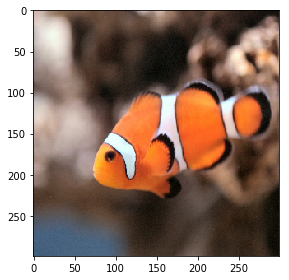

In [142]:
img = data_sets.test.x[35].reshape((img_side,img_side,num_channels)).copy()
render_img(img)

In [189]:
temp = np.zeros(5)
temp2 = np.zeros((1, 5))
temp += temp2
temp.shape

ValueError: non-broadcastable output operand with shape (5,) doesn't match the broadcast shape (1,5)